## gotoflux() function

* fixed on 09/11
* see k2phot_v2 

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os

os.environ['CONDA_DEFAULT_ENV']

'K2phot'

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from glob import glob
import getpass

#fitfiles = glob('new_example_input/*.fits')
fitfiles = glob('/home/jp/data/transit/c14/*.fits.gz')
fitfiles

['/home/jp/data/transit/c14/ktwo201609387-kadenza-lpd-targ.fits.gz',
 '/home/jp/data/transit/c14/ktwo201885041-kadenza-lpd-targ.fits.gz',
 '/home/jp/data/transit/c14/ktwo201497396-kadenza-lpd-targ.fits.gz',
 '/home/jp/data/transit/c14/ktwo201661761-kadenza-lpd-targ.fits.gz',
 '/home/jp/data/transit/c14/ktwo201454088-kadenza-lpd-targ.fits.gz',
 '/home/jp/data/transit/c14/ktwo248662696-kadenza-lpd-targ.fits.gz']

In [6]:
import pandas as pd

df=pd.DataFrame('output/20143921/lightcurve_raw_20143921.txt')
df.head()

ValueError: DataFrame constructor not properly called!

In [8]:
from astropy.io import fits

hdulist=fits.open(fitfiles[0])
hdulist

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f21af2d8690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f21af2f4f10>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f21af303c10>]

In [9]:
#BinTableHDU
rec = hdulist[1].data

In [8]:
rec.dtype

dtype((numpy.record, [('TIME', '>f8'), ('TIMECORR', '>f4'), ('CADENCENO', '>i4'), ('RAW_CNTS', '>i4', (15, 13)), ('FLUX', '>f4', (15, 13)), ('FLUX_ERR', '>f4', (15, 13)), ('FLUX_BKG', '>f4', (15, 13)), ('FLUX_BKG_ERR', '>f4', (15, 13)), ('COSMIC_RAYS', '>f4', (15, 13)), ('QUALITY', '>i4'), ('POS_CORR1', '>f4'), ('POS_CORR2', '>f4')]))

In [9]:
time=rec.TIME
time.shape

(3895,)

In [10]:
f=rec.RAW_CNTS
f.shape

(3895, 15, 13)

In [11]:
fmean=np.nanmean(f,axis=0)
fmean.shape

(15, 13)

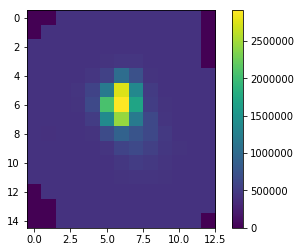

In [12]:
pl.imshow(fmean)
pl.colorbar()

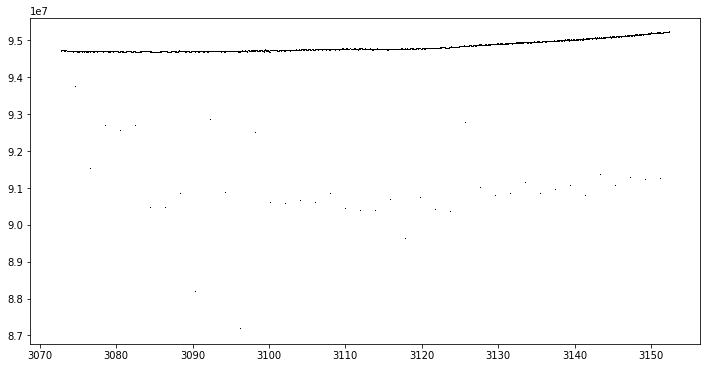

In [14]:
fig = pl.figure(figsize=(12,6))

fpix = f.reshape(f.shape[0], -1)
pl.plot(time, np.nansum(fpix, axis=1), 'k,')
#pl.ylim(4.1e7,4.18e7)

## K2phot

## 2. gotoflux

In [12]:
# read dates and fluxes

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
from glob import glob

#fitfiles = glob('example_input/*.fits')
inputpath='/home/jp/data/transit/'
outputfolder='248662696/'
fitfiles = glob(os.path.join(inputpath,'*.fits'))
filename=fitfiles[0]

# get all files in the folder, just grab the EPIC number of the filename
starnames = np.unique([f[4:13] for f in os.listdir(inputpath) if os.path.isfile(os.path.join(inputpath,f))])
starname=starnames[1] #248662696

def get_pixelfluxes(filename,inputfolder='',outputfolder='',starname=''):
  # Read a pixel file, and return the flux per pixel over time
    
    pixfile=fits.open(fitfiles[0])
    
    Xabs = pixfile[2].header['CRVAL2P'] # X position of pixel on kepler spacecraft
    Yabs = pixfile[2].header['CRVAL1P'] # Y position

    keplerid = pixfile[0].header['KEPLERID']
    kepmag = pixfile[0].header['Kepmag']
    obsmode = pixfile[0].header['OBSMODE']
    channel = pixfile[0].header['CHANNEL']
    module = pixfile[0].header['MODULE']
    RA = pixfile[0].header['RA_OBJ']
    DEC = pixfile[0].header['DEC_OBJ']

    obj_basics = [keplerid,kepmag,obsmode,channel,module,RA,DEC]
    obj_basics_head = '# 0 kepid, 1 kepmag, 2 obsmode, 3 channel, 4 module, 5 RA, 6 DEC'
    np.savetxt(os.path.join(outputfolder,'obj_basics_' + str(starname) + '.txt'),obj_basics,header=obj_basics_head,fmt='%s')

    rec = pixfile[1].data
    dates=rec.TIME
    fluxes=rec.RAW_CNTS
    
    return dates,fluxes,kepmag,Xabs,Yabs

In [13]:
dates,fluxes,kepmag,Xabs,Yabs = get_pixelfluxes(filename,
                                                inputfolder=inputpath,
                                                outputfolder=outputfolder,
                                                starname=starname)

### gotoflux function

In [14]:
from scipy.ndimage import measurements
import matplotlib as mpl
from matplotlib.colors import LogNorm


def find_aperture(dates,fluxes,plot=False,starname='',outputfolder='',kepmag='na',cutoff_limit=2.):
  #
  # This definition reads a 2D array of fluxes (over time) and creates an aperture mask which can later be used to select those pixels for inclusion in light curve
  #

  # first sum all the flux over the different times, this assumes limited movement throughout the time series
    flux = np.nansum(fluxes,axis=0)

    # define which cutoff flux to use for including pixel in mask
    cutoff = cutoff_limit*np.median(flux) # perhaps a more elaborate way to define this could be found in the future but this seems to work pretty well.

    # define the aperture based on cutoff and make it into array of 1 and 0
    aperture =  np.array([flux > cutoff]) #scipy.zeros((np.shape(flux)[0],np.shape(flux)[1]), int)
    aperture = np.array(1*aperture)
    #print aperture
    outline_all = make_aperture_outline(aperture[0]) # an outline (ONLY for figure) of what we are including if we would make no breakups

    # this cool little trick allows us to measure distinct blocks of apertures, and only select the biggest one
    lw, num = measurements.label(aperture) # this numbers the different apertures distinctly
    area = measurements.sum(aperture, lw, index=np.arange(lw.max() + 1)) # this measures the size of the apertures
    aperture = area[lw].astype(int) # this replaces the 1s by the size of the aperture
    aperture = (aperture >= np.max(aperture))*1 # remake into 0s and 1s but only keep the largest aperture

    outline = make_aperture_outline(aperture[0]) # a new outline (ONLY for figure)

    if plot: # make aperture figure
        if not os.path.exists(outputfolder):
            os.makedirs(outputfolder)
        cmap = mpl.cm.get_cmap('Greys', 20)
        pl.figure('Aperture_' + str(starname))
        pl.imshow(flux,norm=LogNorm(),interpolation="none")#,cmap=cmap)
        pl.plot(outline_all[:, 0], outline_all[:, 1],color='green', zorder=10, lw=2.5)
        pl.plot(outline[:, 0], outline[:, 1],color='red', zorder=10, lw=2.5)#,label=str(kepmag))

        #pl.colorbar(orientation='vertical')
        pl.xlabel('X',fontsize=15)
        pl.ylabel('Y',fontsize=15)
        pl.legend()
        #pl.xlim([-1,18])
        #pl.ylim([-1,16])
        #pl.xticks([0,5,10,15])
        #pl.yticks([0,5,10,15])
        pl.tight_layout()
        pl.savefig(os.path.join(outputfolder,'aperture_' + str(starname)+'.pdf'))
        #pl.close()
        #pl.show()
    return aperture

def make_aperture_outline(frame, no_combined_images=1, threshold=0.5):
    ## this is a little module that defines so called outlines to be used for plotting apertures

    thres_val = no_combined_images * threshold
    mapimg = (frame > thres_val)
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])

    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

  # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))


    segments = np.array(l)

    x0 = -0.5
    x1 = frame.shape[1]+x0
    y0 = -0.5
    y1 = frame.shape[0]+y0

    #   now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points
    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]

    return segments

/home/jp/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


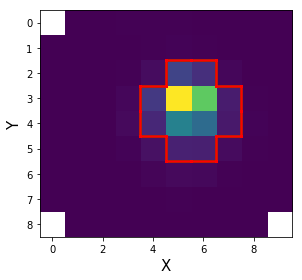

In [15]:
cutoff_limit=1.1 #default from run function

# Define aperture
aperture = find_aperture(dates,fluxes,plot=True,starname=starname,outputfolder=outputfolder,kepmag=kepmag,cutoff_limit=cutoff_limit)

In [16]:
def get_lightcurve(dates,fluxes,aperture,starname='',plot=True,outputfolder='',Xabs=0,Yabs=0):
    '''
    Go from an array of fluxes per pixel (= X,Y,time) to a light curve, 
    by summing the flux in the pixels that are included in the aperture
    
    Get only the fluxes that full in the aperture. 
    Since aperture is defined as 0 everywhere outside we can just multiply
    '''
    
    aperture_fluxes = fluxes*aperture
    background_fluxes = estimate_background(dates,fluxes,aperture,outputfolder=outputfolder,starname=starname)

    # sum over axis 2 and 1 (the X and Y positions), (axis 0 is the time)
    f_t = np.nansum(np.nansum(aperture_fluxes,axis=2), axis=1) - background_fluxes

    # first make a matrix that contains the x and y positions
    x_pixels = [range(0,np.shape(aperture_fluxes)[2])] * np.shape(aperture_fluxes)[1]
    y_pixels = np.transpose([range(0,np.shape(aperture_fluxes)[1])] * np.shape(aperture_fluxes)[2])

    # multiply the position matrix with the aperture fluxes to obtain x_i*f_i and y_i*f_i
    xpos_times_flux = np.nansum( np.nansum( x_pixels*aperture_fluxes, axis=2), axis=1)
    ypos_times_flux = np.nansum( np.nansum( y_pixels*aperture_fluxes, axis=2), axis=1)

    # calculate centroids
    Xc = xpos_times_flux / f_t
    Yc = ypos_times_flux / f_t

    # remove the empty frames (why do they happen?), they have f_t zero
    Xc = np.array(Xc)[f_t > 0]
    Yc = np.array(Yc)[f_t > 0]
    dates = np.array(dates)[f_t > 0]
    f_t = np.array(f_t)[f_t > 0]

    Xc = np.array(Xc) + Xabs
    Yc = np.array(Yc) + Yabs

    if plot:
        # plot flux and centroid curve
        g, (ax1, ax2, ax3) = pl.subplots(3, sharex='col', num='timeseries_'+str(starname))
        ax1.plot(np.array(dates)[f_t>0],f_t[f_t>0],'*') # little hack to avoid values 0 that will skew the plot, but they are not (yet) removed from the LC
        ax1.set_ylabel('Flux [count]')
        ax2.plot(dates,Xc,'*')
        ax2.set_ylabel('Xc')
        ax3.plot(dates,Yc,'*')
        ax3.set_ylabel('Yc')
        ax3.set_xlabel('Time [d]')
        g.savefig(os.path.join(outputfolder,'flux_centroids_' + str(starname) + '.png'))
        #pl.show()

        pl.figure('Raw data')
        pl.plot(np.array(dates)[f_t>0],f_t[f_t>0],'.',color='grey')
        pl.xlabel('Time [d]')
        pl.ylabel('Flux [count]')
        pl.savefig(os.path.join(outputfolder,'raw_data_' + str(starname) + '.png'))
    return [dates,f_t,Xc,Yc]

def estimate_background(dates,fluxes,aperture,outputfolder='',starname=''):
    #
    # estimate the background flux level. this is just the average level of flux on the pixels after correcting for outliers (times the amount of pixels includeed)
    # (note that this may no longer be needed in later versions of K2 data release
    #

    number_of_pixels = np.sum(aperture)

    # estimate background by looking at median, after repeated clipping of what are stars.
    i = 0
    
    #flux_bg_list = [np.median(sigma_clip(np.array(img).ravel(), 3,iterative=False)) for img in fluxes]
    flux_bg_list = []
    while i < len(fluxes):
        flux = np.array(fluxes[i]).ravel()
        flux_clipped = sigma_clip(flux,3,iterative=False)
        flux_bg_list.append(np.median(flux_clipped))
        i = i + 1

    pl.figure()
    pl.plot(dates,flux_bg_list)#,label='')
    pl.xlabel('Time [d]')
    pl.ylabel('Background flux / pixel')
    pl.legend()
    pl.savefig(os.path.join(outputfolder,'background_' + str(starname) + '.png'))
    #pl.show()
    background = number_of_pixels * np.array(flux_bg_list)
    
    return background

def sigma_clip(data,sigma=3,dependent_var=None,iterative=False,top_only=False):
  #
  # Auxiliary to sigma clip, option to run more than once, and to include only top data points (lower outliers may be transit events so we have to be careful what we clip)
  #

    repeat=True
    while repeat:
        # sigma clip data for outliers beyond sigma
        data = np.array(data)
        mean = np.nanmean(data)
        std = np.nanstd(data)
        
        if top_only:
            unclipped = (data < (mean + sigma*std))
        else:
            unclipped = (data < (mean + sigma*std))*(data > (mean - sigma*std)) # array of true and false

        data = data[unclipped]

        if dependent_var is not None:
            dependent_var = np.array(dependent_var)
            dependent_var = dependent_var[unclipped]

        if (iterative and (np.sum(~unclipped) > 0)):
          #	print 'Data points removed:'
          #print np.sum(~unclipped)
          #print 'Repeating..'
          repeat = True

        else:
            #print 'End of sigma clipping, data points removed:'
            #print np.sum(~unclipped)
            repeat = False


    if dependent_var is not None:
        return [data,dependent_var]
    else:
        return data

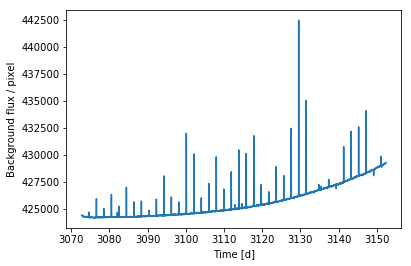

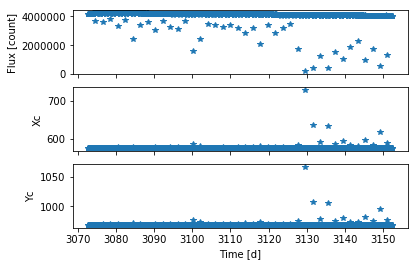

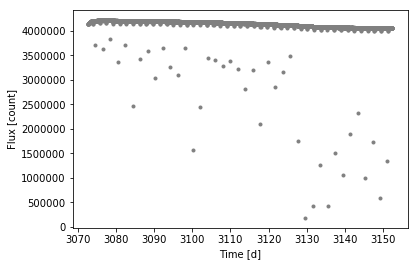

In [17]:
# Create light curve out of fluxes and a fixel aperture
t,f_t,Xc,Yc = get_lightcurve(dates,fluxes,aperture,starname=starname,outputfolder=outputfolder,Xabs=Xabs,Yabs=Yabs)

In [18]:
def remove_known_outliers(t,f_t,Xc,Yc):
    # remove predefined known outliers

    t = np.array(t)
    f_t = np.array(f_t)
    Xc = np.array(Xc)
    Yc = np.array(Yc)
    pl.figure()
    pl.plot(t,f_t,'r.')
    outlier1 = [2064.11,2064.58] # some very large outliers
    outlier2 = [2060.0,2061.4] # very first day is not great
    outliers = [outlier1,outlier2]
    i = 0
    while i < len(outliers):
        mask = ~( (t > outliers[i][0])*(t < outliers[i][1]))
        t = t[mask]
        f_t = f_t[mask]
        Xc = Xc[mask]
        Yc = Yc[mask]
        i = i + 1

        pl.plot(t,f_t,'b.')

    return t,f_t,Xc,Yc

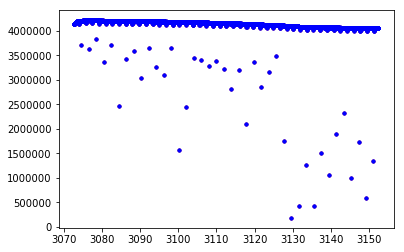

In [19]:
t,f_t,Xc,Yc = remove_known_outliers(t,f_t,Xc,Yc)

In [20]:
def gotoflux(starname,outputpath='',inputpath='',cutoff_limit=2.): #,campaign=1:
    '''
    Read a specific pixel file and extract a light curve from it
    '''
    #filename = 'ktwo' + starname + '-c0' + str(campaign) + '_lpd-targ.fits' # filename as downloaded from MAST
    filename = 'ktwo' + starname + '_lpd-targ.fits' # filename as downloaded from MAST

    outputfolder = os.path.join(outputpath,str(starname))
    if not os.path.exists(outputfolder):
        os.makedirs(outputfolder)

    # Read fluxes per (X,Y) over time
    dates,fluxes,kepmag,Xabs,Yabs = get_pixelfluxes(filename,inputfolder=inputpath,outputfolder=outputfolder,starname=starname)

    # Define aperture
    aperture = find_aperture(dates,fluxes,plot=True,starname=starname,outputfolder=outputfolder,kepmag=kepmag,cutoff_limit=cutoff_limit)

    # Create light curve out of fluxes and a fixel aperture
    t,f_t,Xc,Yc = get_lightcurve(dates,fluxes,aperture,starname=starname,outputfolder=outputfolder,Xabs=Xabs,Yabs=Yabs)

    # Remove simple known outliers
    t,f_t,Xc,Yc = remove_known_outliers(t,f_t,Xc,Yc)

    np.savetxt(os.path.join(outputfolder,'lightcurve_raw_' + str(starname) + '.txt'),np.transpose([t,f_t,Xc,Yc]),header='Time, flux, Xc, Yc')
    np.savetxt(os.path.join(outputfolder,'centroids_' + str(starname) + '.txt'),np.transpose([t,Xc,Yc]),header='Time, Xc, Yc')


    return [t,f_t,Xc,Yc]

## Final pixeltoflux

In [21]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
from scipy.ndimage import measurements
import matplotlib as mpl
from matplotlib.colors import LogNorm

def gotoflux(starname,outputpath='',inputpath='',cutoff_limit=2.): #,campaign=1:
    '''
    Read a specific pixel file and extract a light curve from it
    '''
    #filename = 'ktwo' + starname + '-c0' + str(campaign) + '_lpd-targ.fits' # filename as downloaded from MAST
    filename = 'ktwo' + starname + '_lpd-targ.fits'

    outputfolder = os.path.join(outputpath,str(starname))
    if not os.path.exists(outputfolder):
        os.makedirs(outputfolder)

    # Read fluxes per (X,Y) over time
    dates,fluxes,kepmag,Xabs,Yabs = get_pixelfluxes(filename,inputfolder=inputpath,outputfolder=outputfolder,starname=starname)

    # Define aperture
    aperture = find_aperture(dates,fluxes,plot=True,starname=starname,outputfolder=outputfolder,kepmag=kepmag,cutoff_limit=cutoff_limit)

    # Create light curve out of fluxes and a fixel aperture
    t,f_t,Xc,Yc = get_lightcurve(dates,fluxes,aperture,starname=starname,outputfolder=outputfolder,Xabs=Xabs,Yabs=Yabs)

    # Remove simple known outliers
    t,f_t,Xc,Yc = remove_known_outliers(t,f_t,Xc,Yc)

    np.savetxt(os.path.join(outputfolder,'lightcurve_raw_' + str(starname) + '.txt'),np.transpose([t,f_t,Xc,Yc]),header='Time, flux, Xc, Yc')
    np.savetxt(os.path.join(outputfolder,'centroids_' + str(starname) + '.txt'),np.transpose([t,Xc,Yc]),header='Time, Xc, Yc')


    return [t,f_t,Xc,Yc]

def find_aperture(dates,fluxes,plot=False,starname='',outputfolder='',kepmag='na',cutoff_limit=2.):
  #
  # This definition reads a 2D array of fluxes (over time) and creates an aperture mask which can later be used to select those pixels for inclusion in light curve
  #

  # first sum all the flux over the different times, this assumes limited movement throughout the time series
    flux = np.nansum(fluxes,axis=0)

    # define which cutoff flux to use for including pixel in mask
    cutoff = cutoff_limit*np.median(flux) # perhaps a more elaborate way to define this could be found in the future but this seems to work pretty well.

    # define the aperture based on cutoff and make it into array of 1 and 0
    aperture =  np.array([flux > cutoff]) #scipy.zeros((np.shape(flux)[0],np.shape(flux)[1]), int)
    aperture = np.array(1*aperture)
    #print aperture
    outline_all = make_aperture_outline(aperture[0]) # an outline (ONLY for figure) of what we are including if we would make no breakups

    # this cool little trick allows us to measure distinct blocks of apertures, and only select the biggest one
    lw, num = measurements.label(aperture) # this numbers the different apertures distinctly
    area = measurements.sum(aperture, lw, index=np.arange(lw.max() + 1)) # this measures the size of the apertures
    aperture = area[lw].astype(int) # this replaces the 1s by the size of the aperture
    aperture = (aperture >= np.max(aperture))*1 # remake into 0s and 1s but only keep the largest aperture

    outline = make_aperture_outline(aperture[0]) # a new outline (ONLY for figure)

    if plot: # make aperture figure
        if not os.path.exists(outputfolder):
            os.makedirs(outputfolder)
        cmap = mpl.cm.get_cmap('Greys', 20)
        pl.figure('Aperture_' + str(starname))
        pl.imshow(flux,norm=LogNorm(),interpolation="none")#,cmap=cmap)
        pl.plot(outline_all[:, 0], outline_all[:, 1],color='green', zorder=10, lw=2.5)
        pl.plot(outline[:, 0], outline[:, 1],color='red', zorder=10, lw=2.5)#,label=str(kepmag))

        #pl.colorbar(orientation='vertical')
        pl.xlabel('X',fontsize=15)
        pl.ylabel('Y',fontsize=15)
        pl.legend()
        #pl.xlim([-1,18])
        #pl.ylim([-1,16])
        #pl.xticks([0,5,10,15])
        #pl.yticks([0,5,10,15])
        pl.tight_layout()
        pl.savefig(os.path.join(outputfolder,'aperture_' + str(starname)+'.pdf'))
        #pl.close()
        #pl.show()
    return aperture

def make_aperture_outline(frame, no_combined_images=1, threshold=0.5):
    ## this is a little module that defines so called outlines to be used for plotting apertures

    thres_val = no_combined_images * threshold
    mapimg = (frame > thres_val)
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])

    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

  # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))


    segments = np.array(l)

    x0 = -0.5
    x1 = frame.shape[1]+x0
    y0 = -0.5
    y1 = frame.shape[0]+y0

    #   now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points
    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]

    return segments

def get_lightcurve(dates,fluxes,aperture,starname='',plot=True,outputfolder='',Xabs=0,Yabs=0):
    '''
    Go from an array of fluxes per pixel (= X,Y,time) to a light curve, 
    by summing the flux in the pixels that are included in the aperture
    
    Get only the fluxes that full in the aperture. 
    Since aperture is defined as 0 everywhere outside we can just multiply
    '''
    
    aperture_fluxes = fluxes*aperture
    background_fluxes = estimate_background(dates,fluxes,aperture,outputfolder=outputfolder,starname=starname)

    # sum over axis 2 and 1 (the X and Y positions), (axis 0 is the time)
    f_t = np.nansum(np.nansum(aperture_fluxes,axis=2), axis=1) - background_fluxes

    # first make a matrix that contains the x and y positions
    x_pixels = [range(0,np.shape(aperture_fluxes)[2])] * np.shape(aperture_fluxes)[1]
    y_pixels = np.transpose([range(0,np.shape(aperture_fluxes)[1])] * np.shape(aperture_fluxes)[2])

    # multiply the position matrix with the aperture fluxes to obtain x_i*f_i and y_i*f_i
    xpos_times_flux = np.nansum( np.nansum( x_pixels*aperture_fluxes, axis=2), axis=1)
    ypos_times_flux = np.nansum( np.nansum( y_pixels*aperture_fluxes, axis=2), axis=1)

    # calculate centroids
    Xc = xpos_times_flux / f_t
    Yc = ypos_times_flux / f_t

    # remove the empty frames (why do they happen?), they have f_t zero
    Xc = np.array(Xc)[f_t > 0]
    Yc = np.array(Yc)[f_t > 0]
    dates = np.array(dates)[f_t > 0]
    f_t = np.array(f_t)[f_t > 0]

    Xc = np.array(Xc) + Xabs
    Yc = np.array(Yc) + Yabs

    if plot:
        # plot flux and centroid curve
        g, (ax1, ax2, ax3) = pl.subplots(3, sharex='col', num='timeseries_'+str(starname))
        ax1.plot(np.array(dates)[f_t>0],f_t[f_t>0],'*') # little hack to avoid values 0 that will skew the plot, but they are not (yet) removed from the LC
        ax1.set_ylabel('Flux [count]')
        ax2.plot(dates,Xc,'*')
        ax2.set_ylabel('Xc')
        ax3.plot(dates,Yc,'*')
        ax3.set_ylabel('Yc')
        ax3.set_xlabel('Time [d]')
        g.savefig(os.path.join(outputfolder,'flux_centroids_' + str(starname) + '.png'))
        #pl.show()

        pl.figure('Raw data')
        pl.plot(np.array(dates)[f_t>0],f_t[f_t>0],'.',color='grey')
        pl.xlabel('Time [d]')
        pl.ylabel('Flux [count]')
        pl.savefig(os.path.join(outputfolder,'raw_data_' + str(starname) + '.png'))
    return [dates,f_t,Xc,Yc]

def estimate_background(dates,fluxes,aperture,outputfolder='',starname=''):
    #
    # estimate the background flux level. this is just the average level of flux on the pixels after correcting for outliers (times the amount of pixels includeed)
    # (note that this may no longer be needed in later versions of K2 data release
    #

    number_of_pixels = np.sum(aperture)

    # estimate background by looking at median, after repeated clipping of what are stars.
    i = 0
    
    #flux_bg_list = [np.median(sigma_clip(np.array(img).ravel(), 3,iterative=False)) for img in fluxes]
    flux_bg_list = []
    while i < len(fluxes):
        flux = np.array(fluxes[i]).ravel()
        flux_clipped = sigma_clip(flux,3,iterative=False)
        flux_bg_list.append(np.median(flux_clipped))
        i = i + 1

    pl.figure()
    pl.plot(dates,flux_bg_list)#,label='')
    pl.xlabel('Time [d]')
    pl.ylabel('Background flux / pixel')
    pl.legend()
    pl.savefig(os.path.join(outputfolder,'background_' + str(starname) + '.png'))
    #pl.show()
    background = number_of_pixels * np.array(flux_bg_list)
    
    return background

def sigma_clip(data,sigma=3,dependent_var=None,iterative=False,top_only=False):
  #
  # Auxiliary to sigma clip, option to run more than once, and to include only top data points (lower outliers may be transit events so we have to be careful what we clip)
  #

    repeat=True
    while repeat:
        # sigma clip data for outliers beyond sigma
        data = np.array(data)
        mean = np.nanmean(data)
        std = np.nanstd(data)
        
        if top_only:
            unclipped = (data < (mean + sigma*std))
        else:
            unclipped = (data < (mean + sigma*std))*(data > (mean - sigma*std)) # array of true and false

        data = data[unclipped]

        if dependent_var is not None:
            dependent_var = np.array(dependent_var)
            dependent_var = dependent_var[unclipped]

        if (iterative and (np.sum(~unclipped) > 0)):
          #	print 'Data points removed:'
          #print np.sum(~unclipped)
          #print 'Repeating..'
          repeat = True

        else:
            #print 'End of sigma clipping, data points removed:'
            #print np.sum(~unclipped)
            repeat = False


    if dependent_var is not None:
        return [data,dependent_var]
    else:
        return data
    
def remove_known_outliers(t,f_t,Xc,Yc):
    # remove predefined known outliers

    t = np.array(t)
    f_t = np.array(f_t)
    Xc = np.array(Xc)
    Yc = np.array(Yc)
    pl.figure()
    pl.plot(t,f_t,'r.')
    outlier1 = [2064.11,2064.58] # some very large outliers
    outlier2 = [2060.0,2061.4] # very first day is not great
    outliers = [outlier1,outlier2]
    i = 0
    while i < len(outliers):
        mask = ~( (t > outliers[i][0])*(t < outliers[i][1]))
        t = t[mask]
        f_t = f_t[mask]
        Xc = Xc[mask]
        Yc = Yc[mask]
        i = i + 1

        pl.plot(t,f_t,'b.')

    return t,f_t,Xc,Yc

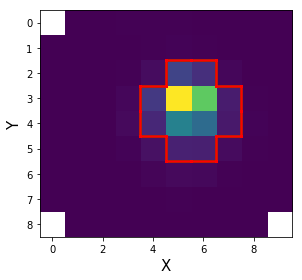

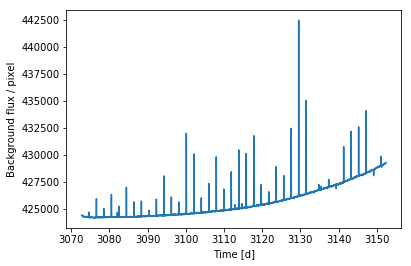

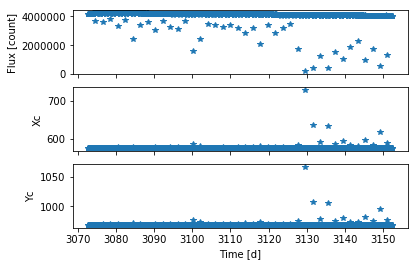

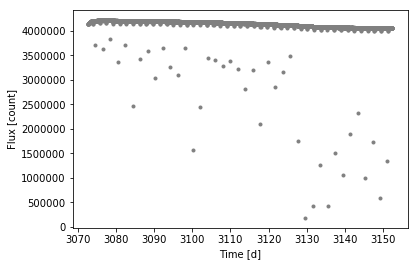

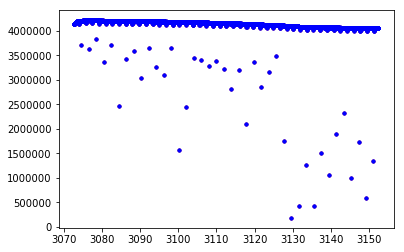

In [22]:
gotoflux(starnames[1],outputpath='.',inputpath=inputpath,cutoff_limit=1.1);

## 2. centroidfit

In [23]:
'''
% Routines to go from MAST pixel files to light curves. Use run_pipeline.run() for regular use of this, or run gotoflux()
% Author Vincent Van Eylen
% Contact vincent@phys.au.dk
% See Van Eylen et al. 2015 (ApJ) for details. Please reference this work if you found this code helpful!
'''

# general python files
import os
import matplotlib.pyplot as pl
import numpy as np
from lmfit import minimize, Parameters

# pipeline files
from auxiliaries import *


def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]

        
def chunks(l, n):
    """ 
    Yield successive n-sized chunks from l.
    """
    for i in xrange(0, len(l), n):
        yield l[i:i+n]

        
def median_filter(time,data,binsize=100):
  # do a running median filter dividing all data points by the median of their immediate surroundings
    i = 0
    data_filtered = []
    while i < len(time):
        bin_begin = max(0, (i - binsize/2))
        bin_end = min(len(time),(i+binsize/2))
        the_bin = data[bin_begin:bin_end]
        the_bin = sorted(the_bin)
        median = np.median(the_bin) #[len(the_bin)/2]
        data_filtered.append(data[i]/median)
        i = i + 1
    return data_filtered


def spitzer_residual(params,time,data,Xc,Yc,robust=True):
    '''
    residual function used for calculating a fit to centroid (and time), 
    borrowed from reducing data for Spitzer
    '''

    # unpack all parameters (note: some may be fixed rather than variable)
    X1 = params['X1'].value
    X2 = params['X2'].value
    X3 = params['X3'].value
    Y1 = params['Y1'].value
    Y2 = params['Y2'].value
    Y3 = params['Y3'].value
    XY1 = params['XY1'].value
    XY2 = params['XY2'].value
    T0 = params['T0'].value
    T1 = params['T1'].value
    T2 = params['T2'].value
    T3 = params['T3'].value
    T4 = params['T4'].value
    TsinAmp = params['TsinAmp'].value
    TsinOff = params['TsinOff'].value

    mean_Xc = np.array(0.) #np.mean(Xc)
    mean_Yc = np.array(0.) #np.mean(Yc)
    time0 = time[0] - 1.#np.array(1994.0) #time[0]-1.

    model = (T0 + TsinAmp*np.sin((time-time0)+TsinOff) + T1*(time-time0) + T2*((time-time0)**2.) + T3*((time-time0)**3.) + T4*((time-time0)**4.) + X1*(Xc-mean_Xc) + X2*((Xc-mean_Xc)**2) + X3*((Xc-mean_Xc)**3) + Y1*(Yc-mean_Yc) + Y2*((Yc-mean_Yc)**2) + Y3*((Yc-mean_Yc)**3) + XY1*(Xc-mean_Xc)*(Yc-mean_Yc) + XY2*((Xc-mean_Xc)**2)*((Yc-mean_Yc)**2))

    residual = np.array(data-model)

    if robust:
        # calculate residual in a robust way
        residual = residual[np.abs(residual) < np.mean(residual) + 3.*np.std(residual)]

    return residual


def find_thruster_events(time,data,Xc,Yc,outputpath='',starname=''):
    '''
    Find events when the spacecruft thruster are fired. 
    Usually no useful data points are gathered when this happens
    '''

    diff_centroid = np.diff(Xc)**2 + np.diff(Yc)**2

    thruster_mask = diff_centroid < (1.5*np.mean(diff_centroid) + 0.*np.std(diff_centroid))
    thruster_mask1 = np.insert(thruster_mask,0, False) # this little trick helps us remove 2 data points each time instead of just 1
    thruster_mask2 = np.append(thruster_mask,False)
    thruster_mask = thruster_mask1*thruster_mask2

    time_thruster = time[ thruster_mask ]
    diff_centroid_thruster = diff_centroid[ thruster_mask[1:] ]

    Xc_clipped = Xc[:][thruster_mask]
    Yc_clipped = Yc[:][thruster_mask]
    time_clipped = time[:][thruster_mask]
    data_clipped = data[:][thruster_mask]


    #pl.figure('Data with / without thruster events')
    #pl.plot(time,data)
    #pl.plot(time_clipped,data_clipped)
    #pl.figure('Differential of centroid movement')
    #pl.plot(time[1:],diff_centroid)
    #pl.plot(time_thruster,diff_centroid_thruster,'*')

    pl.figure()
    pl.plot(time_clipped,data_clipped)
    pl.savefig(os.path.join(outputpath,'raw_nothrusters_' + str(starname) + '.png'))
    np.savetxt(os.path.join(outputpath, 'lightcurve_raw_nothrusters_' + str(starname) + '.txt'),np.transpose([time_clipped,np.array(data_clipped)/np.mean(data_clipped)]),header='Time, Flux')

    return [time_clipped,data_clipped,Xc_clipped,Yc_clipped]


def clean_data(time,data):
    '''
    Module for basic data cleaning up
    '''

    time = time[0:]
    data = data[0:]

    pl.figure('Cleaning up')
    #pl.plot(time,data,'.')
    [data,time] = sigma_clip(data,3,dependent_var=time,top_only=True) # do sigma-clipping (but only at the top of light curve, in bottom outliers may be transit events
    [data,time] = sigma_clip(data,3,dependent_var=time,top_only=True)

    [data,time,lowerbound,upperbound] = running_sigma_clip(data,8,binsize=10,dependent_var=time)
    pl.plot(time,data,'.',color='grey')
    pl.xlabel('Time [d]')
    pl.ylabel('Relative flux')
    return time,data


def spitzer_fit(time,data,Xc,Yc,starname='',outputpath='',chunksize=300):
    '''
    Fit a polynomial to the data and return corrected data
    '''

    outputfolder = os.path.join(outputpath,str(starname))

    # Remove NaN etc.
    time = np.array(time)[np.array(time) > 0.]
    data = np.array(data)[np.array(time) > 0.]
    Xc = np.array(Xc)[np.array(time) > 0.]
    Yc = np.array(Yc)[np.array(time) > 0.]

    data = np.array(data) / np.mean(data)

    params = Parameters() # fitting parameters, set to vary=false to fix
    params.add('X1', value = 0.,vary=True)
    params.add('X2', value = 0.,vary=True)
    params.add('X3', value = 0.,vary=True)
    params.add('Y1', value = 0.,vary=True)
    params.add('Y2', value = 0.,vary=True)
    params.add('Y3', value = 0.,vary=True)
    params.add('XY1', value = 0.,vary=True)
    params.add('XY2', value = 0.,vary=False)
    params.add('T0', value = 0.,vary=True)
    params.add('T1', value = 0.,vary=True)
    params.add('T2', value = 0.,vary=True) #
    params.add('T3', value = 0.,vary=True) #
    params.add('T4', value = 0.,vary=False)
    params.add('TsinAmp', value = 0.,vary=False)
    params.add('TsinOff', value = 0.,vary=False)

    # first divide data in different chunks
    chunksize=chunksize
    time_chunks = list(chunks(time,chunksize))
    data_chunks = list(chunks(data,chunksize))
    Xc_chunks = list(chunks(Xc,chunksize))
    Yc_chunks = list(chunks(Yc,chunksize))

    i = 0
    corrected_data = []
    pl.figure('Data correction Spitzer ' + str(starname))
    while i < len(time_chunks):
        fit = minimize(spitzer_residual, params, args=(time_chunks[i],data_chunks[i],Xc_chunks[i],Yc_chunks[i],False))#,method='leastsq') # first fit is not robust, to get a good first estimate
        fit = minimize(spitzer_residual, fit.params, args=(time_chunks[i],data_chunks[i],Xc_chunks[i],Yc_chunks[i],True))

        final_model = data_chunks[i] - spitzer_residual(fit.params,time_chunks[i],data_chunks[i],Xc_chunks[i],Yc_chunks[i],robust=False)
        corrected_data.append(data_chunks[i] - final_model) # + np.mean(data_chunks[i])

        pl.figure('Data correction Spitzer ' + str(starname))
        pl.plot(time_chunks[i],data_chunks[i],'*',label='Raw data')
        pl.plot(time_chunks[i],final_model,'*',label='Modeled data')

        pl.figure('Corrected data Spitzer ' + str(starname))
        pl.plot(time_chunks[i],corrected_data[i],'*')#,label='Corrected data')

        i = i + 1
    pl.legend()
    pl.savefig(os.path.join(outputfolder, 'centroiddetrended_lightcurve_' + str(starname) + '.png'))


    import itertools # to go from list of lists to one list again
    corrected_time = list(itertools.chain(*time_chunks))
    corrected_data = list(itertools.chain(*corrected_data))

    # finally do a broad running median filtering to remove remaining trends. can be turned off if one wants to keep long term trends
    corrected_data = np.array(median_filter(corrected_time,np.array(corrected_data)+1.,49))-1. #
    corrected_data = np.array(median_filter(corrected_time,np.array(corrected_data)+1.,49))-1. #

    return [corrected_time,corrected_data]

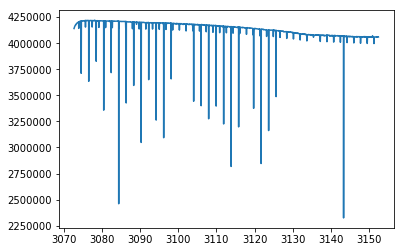

In [25]:
t,f_t,Xc,Yc = find_thruster_events(t,f_t,Xc,Yc,starname=starname,outputpath=outputfolder)

/home/jp/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
auxiliaries.py:91: RuntimeWarning: invalid value encountered in less
  unclipped = (data < (mean + sigma*std))


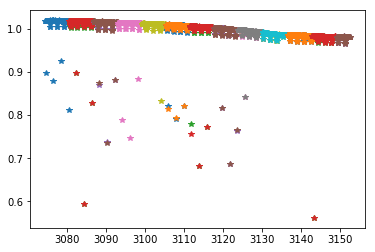

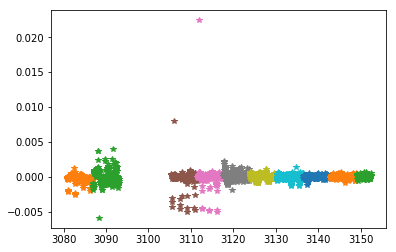

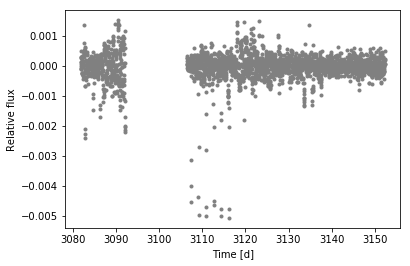

In [30]:
chunksize=300

# now fit a polynomial to the data (inspired by Spitzer data reduction), ignore first data points which are not usually very high-qual
[t,f_t] = spitzer_fit(t[90:],f_t[90:],Xc[90:],Yc[90:],starname=starname,outputpath='.',chunksize=chunksize)
[t,f_t] = clean_data(t,f_t) # do a bit of cleaning
outputlightcurvefolder = os.path.join(outputfolder,'lcs/') # one may want to put the LCs in a different folder e.g. to keep all together

if not os.path.exists(outputlightcurvefolder):
    os.makedirs(outputlightcurvefolder)
np.savetxt(os.path.join(outputlightcurvefolder, 'centroiddetrended_lightcurve_' + str(starname) + '.txt'),np.transpose([t,f_t]),header='Time, Flux')

## 3. periodfinder

In [ ]:
'''
#
# Module to find periodicities of a light curve of flux using BLS. Best periods are automatically folded, other periods are tried and other nice stuff can be done.
# Credit for this Box-least-square (BLS) algorithm goes to Ruth Angus and Dan Foreman-Mackey! See https://github.com/dfm/python-bls, but included here for completeness
#
#
'''

# general python files
import os
import matplotlib.pyplot as pl
import numpy as np

from auxiliaries import *

import bls

def fold_data(t,y,period):
  # simple module to fold data based on period

  folded = t % period
  inds = np.array(folded).argsort()
  t_folded = folded[inds]
  y_folded = y[inds]

  return t_folded,y_folded


def get_period(t,f_t,get_mandelagolmodel=True,outputpath='',starname=''):
  #
  # here we use a BLS algorithm to create a periodogram and find the best periods. The BLS is implemented in Python by Ruth Angus and Dan Foreman-Macey
  #

  outputfolder = os.path.join(outputpath,str(starname))

  fmin = 0.03 # minimum frequency. we can't find anything longer than 90 days obviously
  nf = 60000 # amount of frequencies to try
  df = 0.00001 # frequency step

  qmi = 0.0005 # min relative length of transit (in phase unit)
  qma = 0.1 # max relative length of transit (in phase unit)
  nb = 200 # number of bins in folded LC

  u = np.linspace(fmin,fmin + nf*df,nf)
  v = np.array(0)
  t = np.array(t)
  print t[0]
  f_t = np.array(f_t)

  t_orig = np.copy(t)
  f_t_orig = f_t
  results = bls.eebls(t,f_t,t,f_t,nf,fmin,df,nb,qmi,qma)
  freqlist = u
  powers = results[0]
  period = results[1]

  folded,f_t_folded = fold_data(t,f_t,period)

  np.savetxt(os.path.join(outputfolder, 'folded_P' + str(period) + 'star_' + str(starname) + '.txt'),np.transpose([folded,f_t_folded]),header='Time, Flux')

  t_foldbin,f_t_foldbin,stdv_foldbin = rebin_dataset(folded,f_t_folded,15)
  f_t_smooth = savitzky_golay(f_t_folded,29,1)
  pl.figure('my data folded bls')
  pl.plot(folded,f_t_folded+1.,'.',color='black',label='K2 photometry')
  pl.xlabel('Time [d]')
  pl.ylabel('Relative Flux')

  if get_mandelagolmodel:
    # this is not a core part of the module and uses a transit model by Mandel & Agol, implemented in Python by Ian Crossfield.

    #[T0,b,R_over_a,Rp_over_Rstar,flux_star,gamma1,gamma2]
    transit_params = np.array([4.11176,0.9,0.104,np.sqrt(0.0036),1.,0.2,0.2])
    import model_transits
    times_full = np.linspace(0.,period,10000)
    model = model_transits.modeltransit(transit_params,model_transits.occultquad,period,times_full)

    pl.figure('Transit model')
    pl.scatter((folded-transit_params[0])*24.,f_t_folded+1.,color='black',label='K2 photometry',s=10.)

    pl.plot((times_full-transit_params[0])*24.,model,color='grey',lw=4,label='Transit model')
    pl.xlabel('Time from mid-transit [hr]',fontsize=17)
    pl.ylabel('Relative flux',fontsize=17)
    legend = pl.legend(loc='upper center',numpoints=1,scatterpoints=1,fontsize=15,prop={'size':15},title='EPIC 205071984')
    pl.tick_params(labelsize=17)
    pl.tick_params(axis='both', which='major', width=1.5)

    pl.tight_layout()
    pl.setp(legend.get_title(),fontsize=17)
  pl.savefig(os.path.join(outputfolder, 'folded_P_' + 'star_' + str(starname) +str(period) + '.png'))

  # unravel again
  n_start = int(np.round(t[0] / period))
  n_end = np.round(t[-1] / period) + 1
  i = n_start
  pl.figure()
  pl.plot(t_orig,f_t,'*')

  t_unravel = []
  f_t_unravel = []
  while i < n_end:
    t_unravel.append(np.array(folded) + i*period + t_orig[0])
    f_t_unravel.append(np.array(f_t_smooth))

    pl.plot(t_unravel[i],f_t_unravel[i],color='black',lw='1.5')
    i = i + 1

  print 'best period is '
  print period

  return folded,f_t_folded,period,freqlist,powers


def maskout_freqs(freqs,power,freq=float,lim=0.05):
  # little definition to remove certain frequencies and their nearby surroundings from an array, so that other frequencies can be found which are truly different
  freqs = np.array(freqs)
  power = np.array(power)
  selection = ~((freqs > (freq - lim))*((freqs < (freq + lim))))
  newfreqs = freqs[selection]
  newpower = power[selection]

  return newfreqs,newpower


def make_combo_figure(t,f_t,period,freqs,power,starname='',outputpath=''):
  #
  # This definition can be used to make a single overview figure, showing the lightcurve + a zoom, a BLS periodogram, and folded (+ smoothed) light curves based on the best frequencies and their multiples
  # This figure is used to eyeball good candidates
  #


  t = np.array(t)
  f_t = np.array(f_t)
  freqs = np.array(freqs)
  power = np.array(power)

  pl.figure('Combo figure',figsize=(35.,20.))
  ax1 = pl.subplot2grid((6,3), (0,0), colspan=3,rowspan=2)
  ax2 = pl.subplot2grid((6,3), (2,0), colspan=3)
  ax3 = pl.subplot2grid((6,3), (3,0), colspan=3)
  ax4 = pl.subplot2grid((6,3), (4,0))#, rowspan=2)
  ax5 = pl.subplot2grid((6,3), (4,1))
  ax6 = pl.subplot2grid((6,3), (4,2))
  ax7 = pl.subplot2grid((6,3), (5,0))#, rowspan=2)
  ax8 = pl.subplot2grid((6,3), (5,1))
  ax9 = pl.subplot2grid((6,3), (5,2))

  sn = np.max(power)/np.median(power)
  if sn > 4.:
    titlecolor = 'green'
    outputfigfolder = os.path.join(outputpath,'figs/high_sn/')
  else:
    titlecolor = 'red'
    outputfigfolder = os.path.join(outputpath,'figs/low_sn/')
  pl.suptitle('star = ' + str(starname),fontsize=35,color=titlecolor)
  ax1.plot(t,f_t,'.-')

  ax2.plot(t,f_t,'.-.',lw=0.5)
  ax2.set_ylim([-0.002,0.002])
  ax2.set_xlabel('Time [d]')

  P_min = freqs[-1]
  P_max = freqs[0]
  freq_best = 1./period
  label = ' (Pmin = ' + str(np.round(P_min,3)) + ', Pmax = ' + str(np.round(P_max,3)) + ')'
  freqs = np.array(freqs)
  freqs = 1./freqs
  ax3.plot(freqs,power,'-',lw=0.5,label=label,color='black')
  ax3.axvline(period,lw=3,color='red',label='Period = ' + str(np.round(period,3)))
  ax3.legend(loc='best')


  t_folded,f_t_folded = fold_data(t,f_t,period)
  f_t_smooth = savitzky_golay(f_t_folded,29,1)
  ax4.plot(t_folded,f_t_folded,'.',color='grey',label='Period = ' + str(np.round(period,3))+ ' S/N=' + str(np.round(sn,2)))
  ax4.plot(t_folded,f_t_smooth,color='red',lw=3)
  ax4.legend(loc='best')

  t_folded_2P,f_t_folded_2P = fold_data(t,f_t,period*2.)
  f_t_smooth_2P = savitzky_golay(f_t_folded_2P,29,1)
  ax5.plot(t_folded_2P,f_t_folded_2P,'.',color='grey',label='2 x Period = ' + str(np.round(period*2.,3)))
  ax5.plot(t_folded_2P,f_t_smooth_2P,color='red',lw=3)
  ax5.legend(loc='best')

  t_folded_halfP,f_t_folded_halfP = fold_data(t,f_t,period/2.)
  f_t_smooth_halfP = savitzky_golay(f_t_folded_halfP,29,1)
  ax6.plot(t_folded_halfP,f_t_folded_halfP,'.',color='grey',label='Period/2 = ' + str(np.round(period/2.,3)))
  ax6.plot(t_folded_halfP,f_t_smooth_halfP,color='red',lw=3)
  ax6.legend(loc='best')


  # find next best period, avoid the one already taken, and always avoid 0.5 and 0.25 days
  newfreqs,newpower = maskout_freqs(freqs,power,freq=period)
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=period/2.)
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=period*2.)
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=period*3.)
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=period/3.)

  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=0.25) # spacecraft freqs
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=0.5) # spacecraft freqs
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=0.125) # spacecraft freqs

  newbestfreq2 = newfreqs[np.argmax(newpower)]
  period2 = newbestfreq2
  sn2 = np.max(newpower)/np.median(newpower)

  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=newbestfreq2)
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=newbestfreq2/2.)
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=newbestfreq2*2.)
  newbestfreq3 = newfreqs[np.argmax(newpower)]
  period3 = newbestfreq3
  sn3 = np.max(newpower)/np.median(newpower)

  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=newbestfreq3)
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=newbestfreq3/2.)
  newfreqs,newpower = maskout_freqs(newfreqs,newpower,freq=newbestfreq3*2.)
  newbestfreq4 = newfreqs[np.argmax(newpower)]
  period4 = newbestfreq4
  sn4 = np.max(newpower)/np.median(newpower)

  ax3.axvline(newbestfreq2,lw=2,color='blue',label='Period2 = ' + str(np.round(period2,3)),ls='--')
  ax3.axvline(newbestfreq3,lw=2,color='orange',label='Period3 = ' + str(np.round(period3,3)),ls='--')
  ax3.axvline(newbestfreq4,lw=2,color='green',label='Period4 = ' + str(np.round(period4,3)),ls='--')
  ax3.legend(loc='best',ncol=5)

  t_folded,f_t_folded = fold_data(t,f_t,period2)
  f_t_smooth = savitzky_golay(f_t_folded,29,1)
  ax7.plot(t_folded,f_t_folded,'.',color='grey',label='Period = ' + str(np.round(period2,3))+ ' S/N=' + str(np.round(sn2,2)))
  ax7.plot(t_folded,f_t_smooth,color='blue',lw=3)
  ax7.legend(loc='best')

  t_folded,f_t_folded = fold_data(t,f_t,period3)
  f_t_smooth = savitzky_golay(f_t_folded,29,1)
  ax8.plot(t_folded,f_t_folded,'.',color='grey',label='Period = ' + str(np.round(period3,3))+ ' S/N=' + str(np.round(sn3,2)))
  ax8.plot(t_folded,f_t_smooth,color='orange',lw=3)
  ax8.legend(loc='best')

  t_folded,f_t_folded = fold_data(t,f_t,period4)
  f_t_smooth = savitzky_golay(f_t_folded,29,1)
  ax9.plot(t_folded,f_t_folded,'.',color='grey',label='Period = ' + str(np.round(period4,3))+ ' S/N=' + str(np.round(sn4,2)))
  ax9.plot(t_folded,f_t_smooth,color='green',lw=3)
  ax9.legend(loc='best')


  ax7.set_xlabel('Time [d]')
  ax8.set_xlabel('Time [d]')
  ax9.set_xlabel('Time [d]')
  ax3.set_ylabel('Power')
  ax3.set_xlabel('Period [d]')
  ax1.set_ylabel('Flux')
  ax2.set_ylabel('Flux (zoom)')
  ax4.set_ylabel('Flux')
  ax7.set_ylabel('Flux')
  print 'saving combo figure...'

  if not os.path.exists(outputfigfolder):
    os.makedirs(outputfigfolder)
  pl.savefig(os.path.join(outputfigfolder, 'combo_' + 'star_' + str(starname) + '.png'),figsize=(10.,20.))
